### Imports and Definitions

In [1]:
from gzip import open as gopen
from math import log10
from matplotlib import rcParams
from matplotlib.patches import Patch
from os.path import isfile
from pickle import load,dump
from random import shuffle
from seaborn import pointplot,set_context,set_style,stripplot,violinplot
from treeswift import read_tree_newick
import matplotlib.pyplot as plt
TN93THRESH = 0.015
RC = {"font.size":12,"axes.titlesize":16,"axes.labelsize":14,"legend.fontsize":10,"xtick.labelsize":10,"ytick.labelsize":10}
set_context("paper", rc=RC); set_style("ticks"); rcParams['font.family'] = 'serif'

In [2]:
def p_to_star(p):
    if p <= 0.0001:
        return '****'
    elif p <= 0.001:
        return '***'
    elif p <= 0.01:
        return '**'
    elif p <= 0.05:
        return '*'
    else:
        return ''

### Helper Function to Load FASTA

In [3]:
def read_FASTA(filename):
    seqs = {}
    name = None
    seq = ''
    if filename.lower().endswith('.gz'):
        f = gopen(filename)
    else:
        f = open(filename)
    for line in f:
        if isinstance(line,bytes):
            l = line.decode().strip()
        else:
            l = line.strip()
        if len(l) == 0:
            continue
        if l[0] == '>':
            if name is not None:
                assert len(seq) != 0, "Malformed FASTA"
                seqs[name] = seq
            name = l[1:]
            assert name not in seqs, "Duplicate sequence ID: %s" % name
            seq = ''
        else:
            seq += l
    f.close()
    assert name is not None and len(seq) != 0, "Malformed FASTA"
    seqs[name] = seq
    return seqs

### Helper Function to Load tn93 Output as Distance Matrix

In [4]:
def read_tn93(filename):
    dm = dict()
    if filename.lower().endswith('.gz'):
        f = gopen(filename)
    else:
        f = open(filename)
    for line in f:
        if isinstance(line,bytes):
            l = line.decode().strip()
        else:
            l = line.strip()
        u,v,d = l.split(',')
        if d == 'Distance':
            continue
        d = float(d)
        if u not in dm:
            dm[u] = dict()
        if v not in dm:
            dm[v] = dict()
        dm[u][v] = d; dm[v][u] = d
    return dm

### Helper Functions to Compute Cumulative Moving Average

In [5]:
# compute the average of a list of numbers
def avg(x):
    if len(x) == 0:
        return 0
    return sum(x)/len(x)

# get the Cumulative Moving Average (CMA) over all indices
def cma(x):
    y = [x[0]]
    for i in range(1,len(x)):
        y.append(y[-1]+x[i])
    for i in range(len(y)):
        y[i] /= (i+1)
    return y

# helper function to compute the test statistic
def cma_test_stat(y,normalize=False):
    if normalize:
        sum_miny = sum(cma(sorted(x)))
        return (sum(y)-sum_miny)/(sum(cma(sorted(x,reverse=True)))-sum_miny) # AUC of CMA, normalized so min = 0 and max = 1
    else:
        return sum(y) # AUC of CMA

# returns (stat,p,cma_dist,stat_dist). "side" is "left" or "right"
def cma_test(x,side,it=1000):
    assert side in {'left','right'}, "'side' must be 'left' or 'right'"
    y = cma(x)
    stat = cma_test_stat(y)
    cma_dist = list(); stat_dist = list()
    for _ in range(it):
        tmp = x[:]; shuffle(tmp); tmp_cma = cma(tmp)
        cma_dist.append(tmp_cma)
        stat_dist.append(cma_test_stat(tmp_cma))
    if side == 'right':
        p = sum(e >= stat for e in stat_dist)/len(stat_dist)
    elif side == 'left':
        p = sum(e <= stat for e in stat_dist)/len(stat_dist)
    return stat,p,cma_dist,stat_dist

### Helper Functions to Compute Pairwise Probability Test

In [6]:
# compute the pairwise probability score
def pairprob(om,num):
    c = 0.; n = 0.
    if num is None: # compare each i-th person against each (j>i)-th person
        bins = dict()
        for i,e in reversed(list(enumerate(om))):
            if e not in bins:
                bins[e] = list()
            bins[e].append(i)
        vals = sorted(bins.keys(),reverse=True)
        for vi in range(len(vals)-1):
            for vj in range(vi+1,len(vals)):
                n += len(bins[vals[vi]])*len(bins[vals[vj]])
                for i in bins[vals[vi]]:
                    for j in bins[vals[vj]]:
                        if i < j:
                            c += 1
    else: # compare each (i<num)-th person against each (j>=num)-th person
        pass
    return c/n

# helper function to compute the test statistic
def pairprob_stat(om,num):
    return pairprob(om,num)

# returns (stat,p,stat_dist)
def pairprob_test(om,num,side,it=1000):
    assert side in {'left','right'}, "'side' must be 'left' or 'right'"
    pp = pairprob_stat(om,num)
    pp_dist = list()
    for _ in range(it):
        tmp = om[:]; shuffle(tmp); pp_dist.append(pairprob_stat(tmp,num))
    if side == 'right':
        p = sum(e >= pp for e in pp_dist)/len(pp_dist)
    elif side == 'left':
        p = sum(e <= pp for e in pp_dist)/len(pp_dist)
    return pp,p,pp_dist

# Real Data

### Load Data

In [7]:
data = {
    'seqs': read_FASTA('../real_data/sd.full.aln.gz'),
    'tn93': read_tn93('../real_data/sd.full.tn93.csv.gz'),
    'time': {t:{l.decode().strip().split()[0]:int(l.decode().strip().split()[1]) for l in gopen('../real_data/sd.time.%s.tsv.gz'%t)} for t in ['sample','diagnosis','infection']},
    'proact': {n:{t:{s:{m:gopen('../real_data/sd.%s.%s.mv.proact.%s.%s.txt.gz'%(n,t,s,m)).read().decode().strip().splitlines() for m in ['feedback','oldmode']} for s in ['sample']} for t in ['ft','iq']} for n in ['10','20','30','40','50','60','70','80','90','full']},
    'hivtrace': {n:gopen('../real_data/sd.%s.hivtrace.txt.gz'%n).read().decode().strip().splitlines() for n in ['10','20','30','40','50','60','70','80','90','full']}
}
metareal = {
    'label': {
        'ft': 'FastTree',
        'iq': 'IQ-TREE',
        'feedback': 'ProACT',
        'oldmode': 'ProACT (No Feedback)',
        'max': 'Optimal',
        'bg': 'Background',
        'hivtrace': 'GD + Cluster Growth'
    },
    'color': {
        'ft': 'green',
        'iq': 'blue',
        'max': 'black',
        'bg': 'lightgrey',
        'hivtrace': 'orange'
    }
}

## Metric: 1/(average time between me and HIV-TRACE link)

### Cumulative Moving Average (CMA) Test

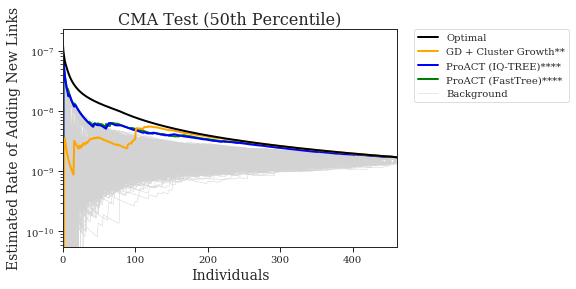

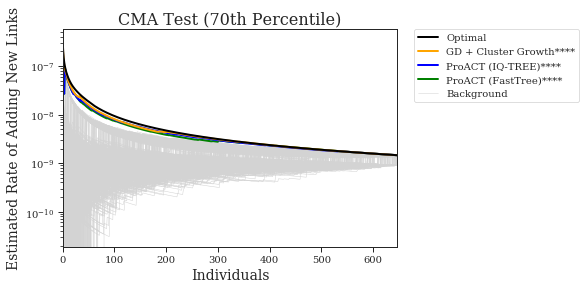

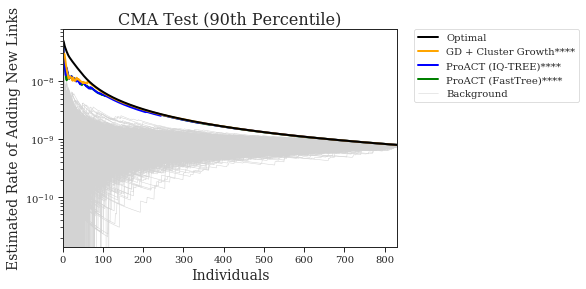

In [8]:
IT = 10000
for per in ['50','70','90']: # doing 50th, 70th, and 90th percentiles
    END = max(int(l.split('_')[-1]) for l in data['proact'][per]['ft']['sample']['feedback'])
    for s in ['sample']:
        fig = plt.figure()
        pronew_y = dict()
        pronew_pstr = dict()
        for t in ['ft','iq','hivtrace']:
            if t in {'ft','iq'}:
                currdata = data['proact'][per][t][s]['feedback']
            else:
                currdata = data['hivtrace'][per]
            x = list(range(len(currdata)))
            pronew = [avg([data['time'][s][v]-data['time'][s][u] for v in data['tn93'][u] if data['tn93'][u][v] <= TN93THRESH and data['time'][s][v] > END]) if u in data['tn93'] else 0 for u in currdata]
            pronew = [0 if e == 0 else 1./e for e in pronew]
            pronew_y[t] = cma(pronew)
            pronew_stat,pronew_p,cma_dist,stat_dist = cma_test(pronew,'right',it=IT)
            pronew_pstr[t] = "{:.{}f}".format(pronew_p,int(log10(IT)))
            opt_y = cma(sorted(pronew,reverse=True))
        plt.plot(x,cma_dist[0],color=metareal['color']['bg'],linewidth=0.5,label=metareal['label']['bg'])
        for bg in cma_dist[1:min(len(cma_dist),1000)]: # background distribution
                plt.plot(x,bg,color=metareal['color']['bg'],linewidth=0.5)
        for t in ['ft','iq','hivtrace']:
            if t in {'ft','iq'}:
                currlabel = "%s (%s)%s"%(metareal['label']['feedback'],metareal['label'][t],p_to_star(float(pronew_pstr[t])))
            else:
                currlabel = "%s%s"%(metareal['label']['hivtrace'],p_to_star(float(pronew_pstr[t])))
            plt.plot(x,pronew_y[t],color=metareal['color'][t],linewidth=2,label=currlabel) # ProACT feedback result
        plt.plot(x,opt_y,color=metareal['color']['max'],linewidth=2,label=metareal['label']['max']) # max possible
        plt.xlim(xmin=0,xmax=max(x))
        plt.gca().set_yscale('log')
        handles,labels = fig.gca().get_legend_handles_labels()
        plt.legend(handles[::-1],labels[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.title("CMA Test (%sth Percentile)"%per)
        plt.xlabel("Individuals")
        plt.ylabel("Estimated Rate of Adding New Links")
        fig.savefig('results_cmatest_p%s.pdf'%per, format='pdf', bbox_inches='tight')

### Pairwise Probability Test

ProACT, FastTree
10-th Percentile: p = 0.0
20-th Percentile: p = 0.0
30-th Percentile: p = 0.0
40-th Percentile: p = 0.0
50-th Percentile: p = 0.0
60-th Percentile: p = 0.0
70-th Percentile: p = 0.0
80-th Percentile: p = 0.0
90-th Percentile: p = 0.0

ProACT, IQ-TREE
10-th Percentile: p = 0.0
20-th Percentile: p = 0.0
30-th Percentile: p = 0.0
40-th Percentile: p = 0.0
50-th Percentile: p = 0.0
60-th Percentile: p = 0.0
70-th Percentile: p = 0.0
80-th Percentile: p = 0.0
90-th Percentile: p = 0.0

ProACT, GD + Cluster Growth
10-th Percentile: p = 0.0
20-th Percentile: p = 0.0
30-th Percentile: p = 0.0
40-th Percentile: p = 0.0
50-th Percentile: p = 0.0
60-th Percentile: p = 0.0
70-th Percentile: p = 0.0
80-th Percentile: p = 0.0
90-th Percentile: p = 0.0



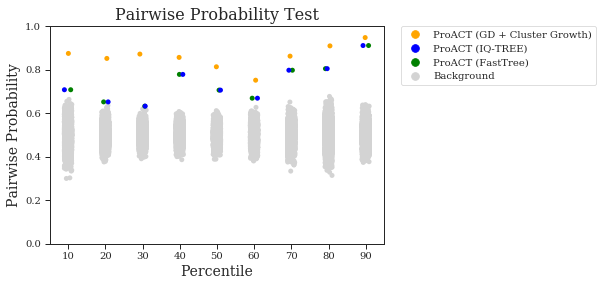

In [9]:
IT = 1000; ymin = 0; ymax = 1
for s in ['sample']:
    fig = plt.figure()
    x = list(); y = list(); hue = list(); pal = list(); tmp = list(); pal = [metareal['color']['bg']]
    for m in ['feedback']:
        for t in ['ft','iq','hivtrace']:
            print("%s, %s"%(metareal['label'][m],metareal['label'][t]))
            for per in ['10','20','30','40','50','60','70','80','90']:
                if t in {'ft','iq'}:
                    currdata = data['proact'][per]['ft']['sample']['feedback']
                else:
                    currdata = data['hivtrace'][per]
                END = max(int(l.split('_')[-1]) for l in currdata)
                val = [avg([data['time'][s][v]-data['time'][s][u] for v in data['tn93'][u] if data['tn93'][u][v] <= TN93THRESH and data['time'][s][v] > END]) if u in data['tn93'] else 0 for u in currdata]
                val = [0 if e == 0 else 1./e for e in val]
                pp,p,pp_dist = pairprob_test(val,None,'right',it=IT)
                pstr = "{:.{}f}".format(p,int(log10(IT)))
                print("%s-th Percentile: p = %s" % (per,p))
                for bg in pp_dist:
                    x.append(per); y.append(bg); hue.append(metareal['label']['bg'])
                tmp.append((per,pp,r"%s (%s)"%(metareal['label']['feedback'],metareal['label'][t]),metareal['color'][t]))
            print()
    for per,pp,h,c in tmp:
        x.append(per); y.append(pp); hue.append(h)
        if c not in pal:
            pal.append(c)
    stripplot(x=x,y=y,hue=hue,palette=pal,jitter=True)
    handles,labels = fig.gca().get_legend_handles_labels()
    plt.legend(handles[::-1],labels[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim(ymin=ymin,ymax=ymax)
    plt.title("Pairwise Probability Test")
    plt.xlabel("Percentile")
    plt.ylabel("Pairwise Probability")
    fig.savefig('results_pairprobtest.pdf', format='pdf', bbox_inches='tight')

# Simulated Data

### Load Data

In [10]:
eff = load(gopen('../simulations/efficacy.pkl.gz'))
metasim = {
    'label': {
        'expected': 'Expected',
        'optimal': 'Optimal',
        'hivtrace': 'GD + Cluster Growth',
        'proact.feedback.true': 'ProACT (True Trees)',
        'proact.feedback.ftmv': 'ProACT (FastTree)',
        'proact.oldmode.true': 'ProACT (No Feedback, True Trees)',
        'proact.oldmode.ftmv': 'ProACT (No Feedback, FastTree)',
        'SAMPLE-END_ARTRATE-1': r'ART Rate 1 year$^{-1}$ (Sample End)',
        'SAMPLE-END_ARTRATE-2': r'ART Rate 2 year$^{-1}$ (Sample End)',
        'SAMPLE-END_ARTRATE-4': r'ART Rate 4 year$^{-1}$ (Sample End)',
        'SAMPLE-FIRSTART_ARTRATE-0.5': r'ART Rate 0.5 year$^{-1}$',
        'SAMPLE-FIRSTART_ARTRATE-1': r'ART Rate 1 year$^{-1}$',
        'SAMPLE-FIRSTART_ARTRATE-2': r'ART Rate 2 year$^{-1}$',
        'SAMPLE-FIRSTART_ARTRATE-4': r'ART Rate 4 year$^{-1}$',
        'SAMPLE-FIRSTART_EXPDEGREE-20': 'Expected Degree 20',
        'SAMPLE-FIRSTART_EXPDEGREE-30': 'Expected Degree 30',
    },
    'color': {
        'expected': 'lightgrey',
        'optimal': 'black',
        'hivtrace': 'orange',
        'proact.feedback.true': 'lightblue',
        'proact.feedback.ftmv': 'blue',
        'proact.oldmode.true': 'lightgreen',
        'proact.oldmode.ftmv': 'green',
        'SAMPLE-FIRSTART_ARTRATE-1': 'lightblue',
        'SAMPLE-FIRSTART_ARTRATE-2': 'blue',
        'SAMPLE-FIRSTART_ARTRATE-4': 'darkblue',
        'SAMPLE-END_ARTRATE-1': 'lightgreen',
        'SAMPLE-END_ARTRATE-2': 'green',
        'SAMPLE-END_ARTRATE-4': 'darkgreen',
        'SAMPLE-FIRSTART_EXPDEGREE-20': 'orange',
        'SAMPLE-FIRSTART_EXPDEGREE-30': 'red',
    },
    'linestyle': {
        'expected': '--',
        'optimal': '--',
        'hivtrace': '-.',
        'proact.feedback.true': '-',
        'proact.feedback.ftmv': '-',
        'proact.oldmode.true': '-',
        'proact.oldmode.ftmv': '-',
        'SAMPLE-FIRSTART_ARTRATE-1': '-',
        'SAMPLE-FIRSTART_ARTRATE-2': '-',
        'SAMPLE-FIRSTART_ARTRATE-4': '-',
        'SAMPLE-END_ARTRATE-1': '-',
        'SAMPLE-END_ARTRATE-2': '-',
        'SAMPLE-END_ARTRATE-4': '-',
        'SAMPLE-FIRSTART_EXPDEGREE-20': '-',
        'SAMPLE-FIRSTART_EXPDEGREE-30': '-',
    }
}

## Metric: Number of Infections After Year 9

### Comparing Methods

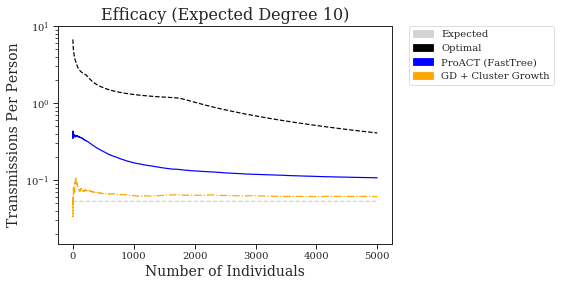

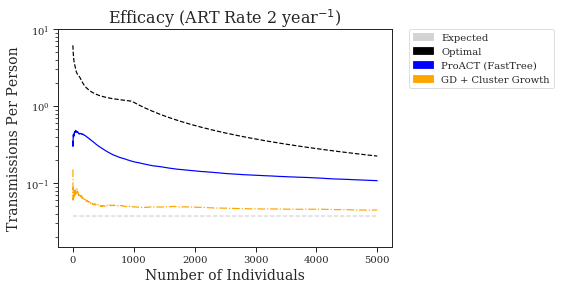

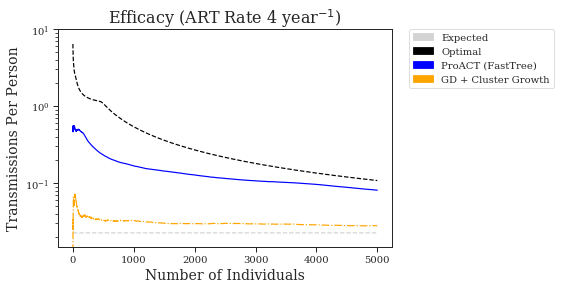

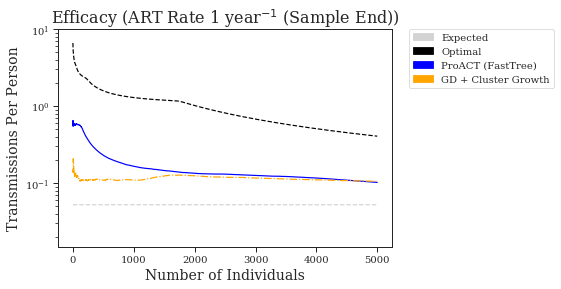

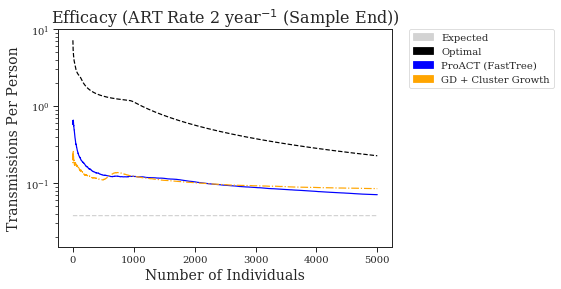

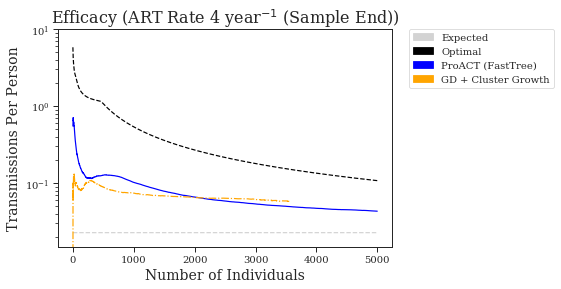

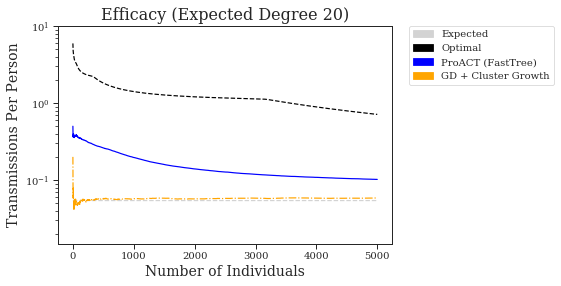

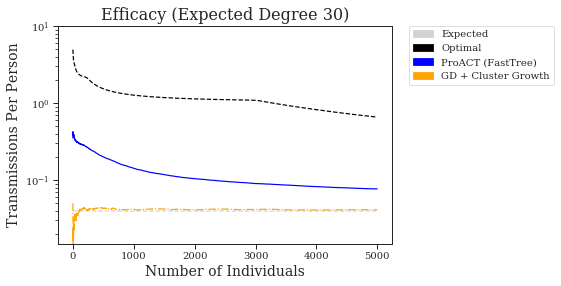

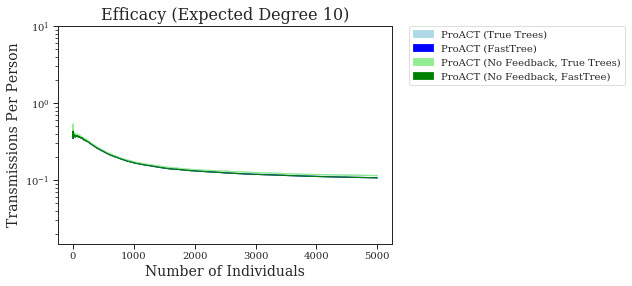

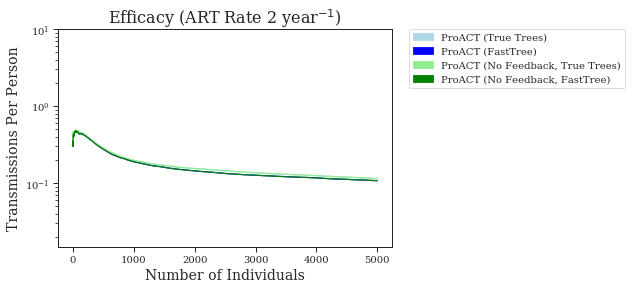

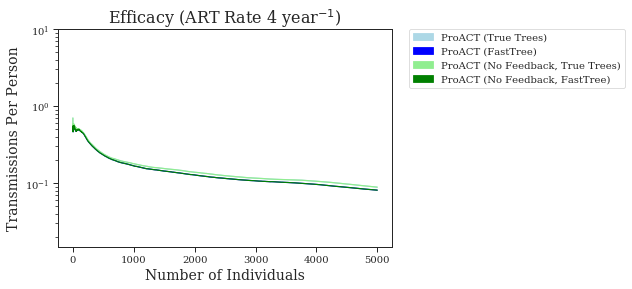

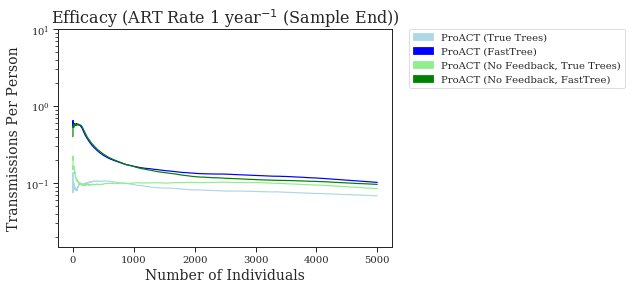

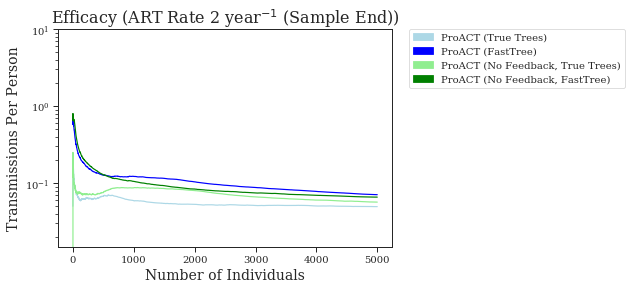

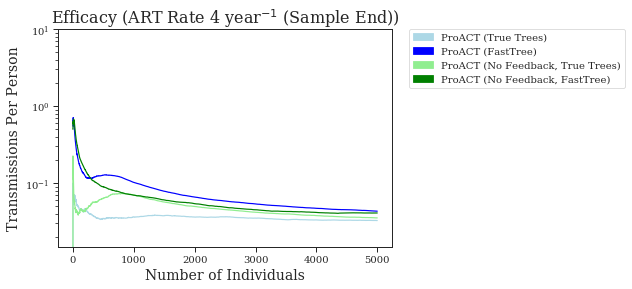

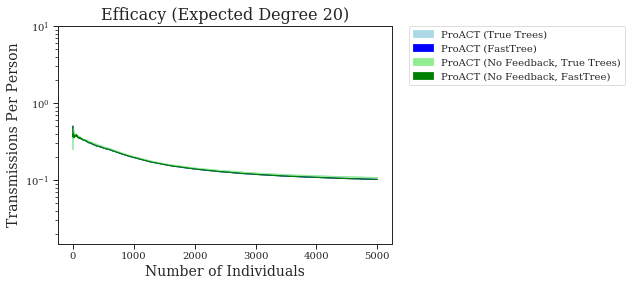

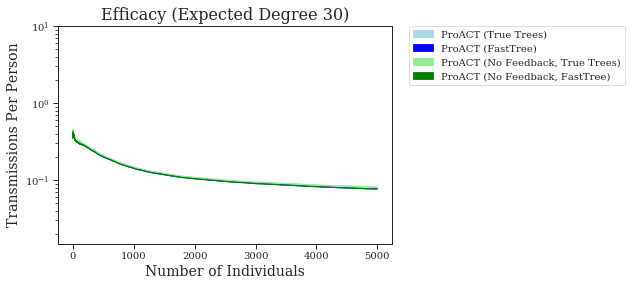

In [11]:
Ms = {
    'main': ['expected','optimal','proact.feedback.ftmv','hivtrace'],
    'sup': ['proact.feedback.true','proact.feedback.ftmv','proact.oldmode.true','proact.oldmode.ftmv'],
}
Ks = ['SAMPLE-FIRSTART_ARTRATE-1','SAMPLE-FIRSTART_ARTRATE-2','SAMPLE-FIRSTART_ARTRATE-4','SAMPLE-END_ARTRATE-1','SAMPLE-END_ARTRATE-2','SAMPLE-END_ARTRATE-4','SAMPLE-FIRSTART_EXPDEGREE-20','SAMPLE-FIRSTART_EXPDEGREE-30']
ymin = 1.5*(10**-2); ymax = 10
for part,M in Ms.items():
    handles = [Patch(color=metasim['color'][m], label=metasim['label'][m]) for m in M]
    for K in Ks:
        fig = plt.figure()
        for m in M:
            x = list(range(len(eff[m][K][0])))
            cmas = [cma(l) for l in eff[m][K]]
            y = [avg([c[i] for c in cmas if i < len(c)]) for i in x]
            plt.plot(x, y, color=metasim['color'][m], linestyle=metasim['linestyle'][m], label=metasim['label'][m])
        plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.gca().set_yscale('log')
        plt.ylim(ymin=ymin,ymax=ymax)
        plt.title("Efficacy (%s)" % metasim['label'][K])
        plt.xlabel("Number of Individuals")
        plt.ylabel("Transmissions Per Person")
        fig.savefig('results_efficacy_%s_%s.pdf'%(K,part), format='pdf', bbox_inches='tight')
        if K == 'SAMPLE-FIRSTART_ARTRATE-1':
            plt.title("Efficacy (Expected Degree 10)")
            fig.savefig('results_efficacy_SAMPLE-FIRSTART_EXPDEGREE-10_%s.pdf'%part, format='pdf', bbox_inches='tight')

### Comparing Model Conditions

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


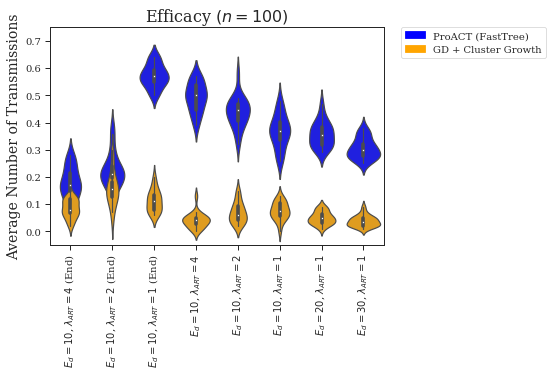

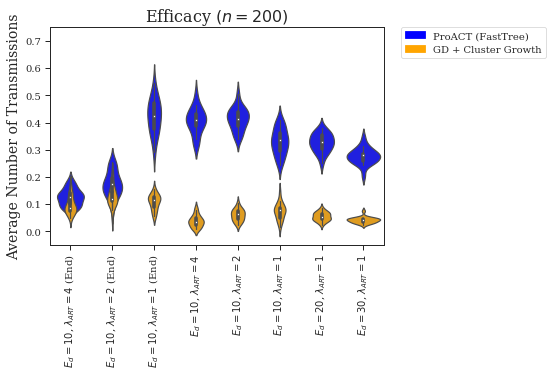

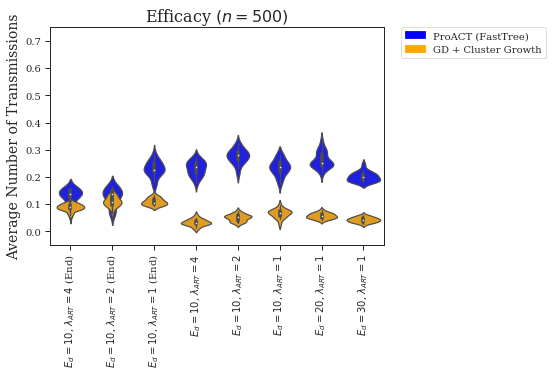

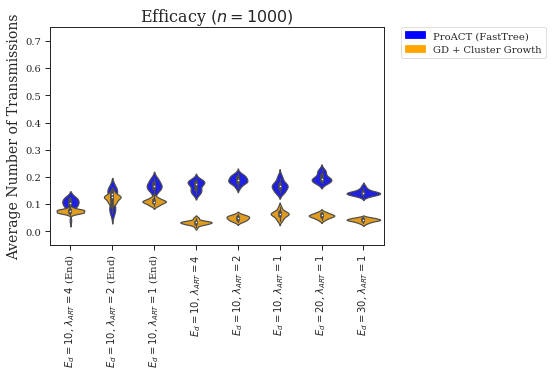

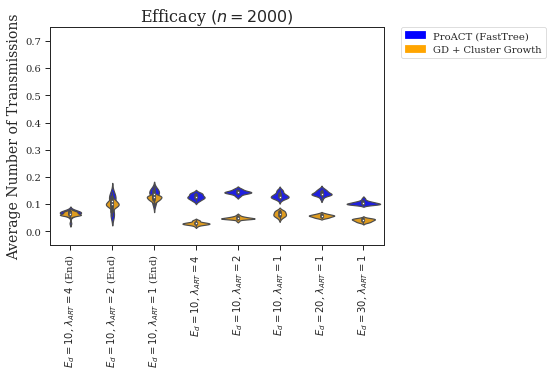

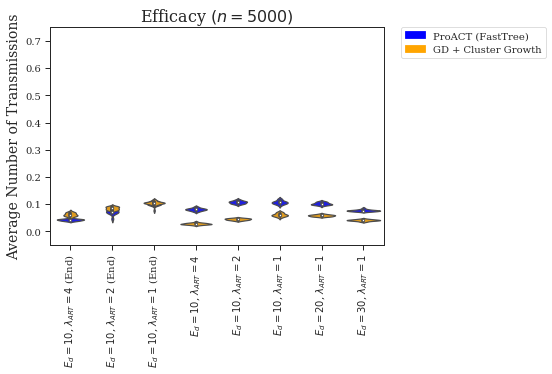

In [12]:
Ks = ['SAMPLE-END_ARTRATE-4','SAMPLE-END_ARTRATE-2','SAMPLE-END_ARTRATE-1','SAMPLE-FIRSTART_ARTRATE-4','SAMPLE-FIRSTART_ARTRATE-2','SAMPLE-FIRSTART_ARTRATE-1','SAMPLE-FIRSTART_EXPDEGREE-20','SAMPLE-FIRSTART_EXPDEGREE-30']
tr = {
    'SAMPLE-FIRSTART_ARTRATE-1': r'$E_{d}=10$, $\lambda_{ART}=1$',
    'SAMPLE-FIRSTART_ARTRATE-2': r'$E_{d}=10$, $\lambda_{ART}=2$',
    'SAMPLE-FIRSTART_ARTRATE-4': r'$E_{d}=10$, $\lambda_{ART}=4$',
    'SAMPLE-FIRSTART_EXPDEGREE-20': r'$E_{d}=20$, $\lambda_{ART}=1$',
    'SAMPLE-FIRSTART_EXPDEGREE-30': r'$E_{d}=30$, $\lambda_{ART}=1$',
    'SAMPLE-END_ARTRATE-1': r'$E_{d}=10$, $\lambda_{ART}=1$ (End)',
    'SAMPLE-END_ARTRATE-2': r'$E_{d}=10$, $\lambda_{ART}=2$ (End)',
    'SAMPLE-END_ARTRATE-4': r'$E_{d}=10$, $\lambda_{ART}=4$ (End)',
}
Ms = ['proact.feedback.ftmv','hivtrace']
Ns = [100,200,500,1000,2000,5000]
handles = [Patch(color=metasim['color'][m], label=metasim['label'][m]) for m in Ms]
ymin = -0.05; ymax = 0.75
for n in Ns:
    fig = plt.figure()
    for m in Ms:
        x = list(); y = list()
        for K in Ks:
            y += [avg(l[:n]) for l in eff[m][K]]; x += [tr[K]]*len(eff[m][K])
        violinplot(x=x, y=y, color=metasim['color'][m], labels=metasim['label'][m])
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim(ymin=ymin,ymax=ymax) #plt.gca().set_yscale('log')
    plt.title(r"Efficacy $(n=%d)$" % n)
    plt.ylabel("Average Number of Transmissions")
    plt.xticks(rotation=90)
    fig.savefig('results_efficacy_n%d.pdf'%n, format='pdf', bbox_inches='tight')